In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define basic data

In [6]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [55]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)


# because the last two decade used different untouched sample, 
# so here we merge them together
Untouched_sample = [Sample_Landsat] * 8 + [Sample_Sentinel] * 2

#### Calculate the accuracy of GAIA datasets

In [29]:
# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

In [30]:
# get the GAIA area change
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# add {2019:1} to the dictionary, because GAIA does not 
# extend to 2019, we just use its latest pixel of 2018
GAIA_value.update({2019:1})

# here we get each end year (1992,1995,...,2019) from GAIA
# set the target year's value to 1, others to 0
GAIA_each_year = [ee.Image(GAIA_img.gte(GAIA_value[year])) 
                  for year in range(1992,2020,3)]

In [56]:
# calculate the GAIA accuracy using the untouched control samples

GAIA_acc = []

for i,year in enumerate(range(1992,2020,3)):
    
    # get the img and untouched sample
    sample = Untouched_sample[i]
    img    = GAIA_each_year[i]
    
    # rename the band so we can use Accuracy_assesment module
    img = img.rename('classification')
    
    # extract reclassified GAIA pixel value to test_sample
    test_with_GAIA = img.sampleRegions( collection = sample, 
                                        properties = ['Built'], 
                                        scale      = 30)

    # compute the accuracy 
    GAIA_acc.append(Accuracy_assesment(test_with_GAIA).Stp_1_Calculate_Accuracy())
    
    # print out the process
    print(f'Accuracy computation of GAIA_{year} complete!')
    

Accuracy computation of GAIA_1992 complete!
Accuracy computation of GAIA_1995 complete!
Accuracy computation of GAIA_1998 complete!
Accuracy computation of GAIA_2001 complete!
Accuracy computation of GAIA_2004 complete!
Accuracy computation of GAIA_2007 complete!
Accuracy computation of GAIA_2010 complete!
Accuracy computation of GAIA_2013 complete!
Accuracy computation of GAIA_2016 complete!
Accuracy computation of GAIA_2019 complete!


In [14]:
# # Formatting the GAIA_accuracy dataframe
# GAIA_acc_df = pd.DataFrame(GAIA_acc)

# # save to disk
# GAIA_acc_df.to_csv('./Result/GAIA_acc.csv',index=False)

# load the df
GAIA_acc_df = pd.read_csv('./Result/GAIA_acc.csv')
GAIA_acc_df['Year'] = year_range

#####  Calculate the accuracy of my result using untouched control samples

In [49]:
# get the temporal_check classification images
Checked_my = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/forward_backward_Window_3_It_9_{year}")
               for year in year_range]


In [60]:
My_acc = []

for year,img,sample in zip(year_range,Checked_my,Untouched_sample):
    
    # rename the band so we can use Accuracy_assesment module
    img = img.rename('classification')
    
    # extract reclassified GAIA pixel value to test_sample
    test_with_mine = img.sampleRegions( collection = sample, 
                                        properties = ['Built'], 
                                        scale      = 30)

    # compute the accuracy 
    My_acc.append(Accuracy_assesment(test_with_mine).Stp_1_Calculate_Accuracy())
    
    # print out the process
    print(f'Accuracy computation of My_{year} complete!')
    

Accuracy computation of My_1990_1992 complete!
Accuracy computation of My_1993_1995 complete!
Accuracy computation of My_1996_1998 complete!
Accuracy computation of My_1999_2001 complete!
Accuracy computation of My_2002_2004 complete!
Accuracy computation of My_2005_2007 complete!
Accuracy computation of My_2008_2010 complete!
Accuracy computation of My_2011_2013 complete!
Accuracy computation of My_2014_2016 complete!
Accuracy computation of My_2017_2019 complete!


In [9]:
# # Formatting the GAIA_accuracy dataframe
# My_acc_df = pd.DataFrame(My_acc)

# # save to disk
# My_acc_df.to_csv('./Result/My_acc.csv',index=False)

# load the df
My_acc_df = pd.read_csv('./Result/My_acc.csv')

In [10]:
My_acc_df['Year'] = year_range
My_acc_df

,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built,Year
0,99.55,99.10,100.00,100.00,99.09,1990_1992
1,99.60,99.20,100.00,100.00,99.19,1993_1995
2,99.75,99.50,100.00,100.00,99.50,1996_1998
3,99.65,99.40,99.90,99.90,99.40,1999_2001
4,99.60,99.20,100.00,100.00,99.19,2002_2004
5,99.44,99.10,99.80,99.80,99.09,2005_2007
6,99.39,98.90,99.90,99.90,98.89,2008_2010
7,98.99,98.30,99.69,99.70,98.29,2011_2013
8,98.81,99.41,98.20,98.25,99.39,2014_2016
9,98.66,99.12,98.20,98.25,99.09,2017_2019


##### Make a figure for comparison

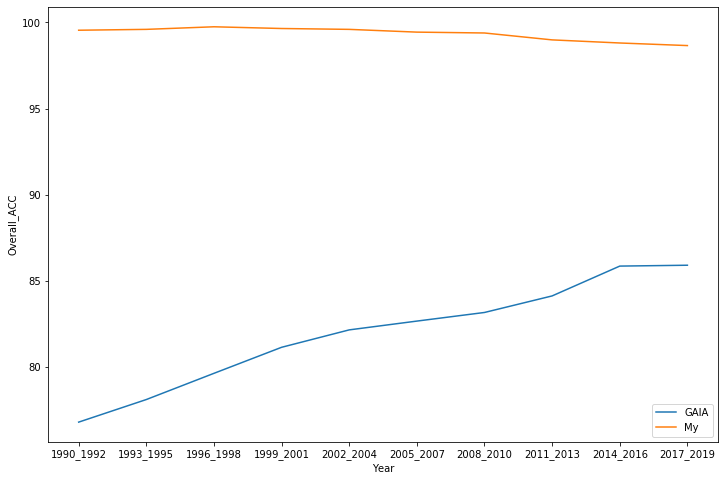

In [16]:
plt.figure(figsize=(12,8))

sns.lineplot(data=GAIA_acc_df,x = 'Year', y ='Overall_ACC', label='GAIA')
sns.lineplot(data=My_acc_df  ,x = 'Year', y ='Overall_ACC', label='My')